data source: https://www.kaggle.com/competitions/ieee-fraud-detection/data
notebook ref: https://www.kaggle.com/code/artgor/eda-and-models

## General information

In this kernel I work with IEEE Fraud Detection competition.

EEE-CIS works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with the world’s leading payment service company, Vesta Corporation, seeking the best solutions for fraud prevention industry, and now you are invited to join the challenge.

We have a binary classification problem with a heavy imbalance which is an inherent property of such problems.
At first I'll explore the data and try to find valuable insights, maybe I'll do some feature engineering and then it wil be time to build models.

![](https://cis.ieee.org/images/files/slideshow/abstract01.jpg)

*Work in progress*

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import eli5
import shap
from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

#alt.renderers.enable('notebook')

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


## Functions used in this kernel
They are in the hidden cell below.

In [2]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from IPython.display import HTML

# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """
    # Use a default Vega version if needed, or skip if not required for your charts
    vega_url = 'https://cdn.jsdelivr.net/npm/vega@5'
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id=\"{id}\"></div><script>
    require([\"vega-embed\"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed(\"#{id}\", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log(\"anything?\");
    }});
    console.log(\"really...anything?\");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True

def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

## Data loading and overview

Data is separated into two datasets: information about the identity of the customer and transaction information. Not all transactions belong to identities, which are available. Maybe it would be possible to use additional transactions to generate new features.

In [3]:
folder_path = '../data/raw/ieee-fraud-detection/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [4]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


So we have two medium-sized datasets with a lot of columns. Train and test data have similar number of rows

In [5]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
del train_identity, train_transaction, test_identity, test_transaction

In [8]:
print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')

There are 414 columns in train dataset with missing values.


In [9]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [10]:
print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


Most of columns have missing data, which is normal in real world. Also there are columns with one unique value (or all missing). There are a lot of continuous variables and some categorical. Let's have a closer look at them.

## Data Exploration
Let's start with identity information.
id_01 - id_11 are continuous variables, id_12 - id_38 are categorical and the last two columns are obviously also categorical.

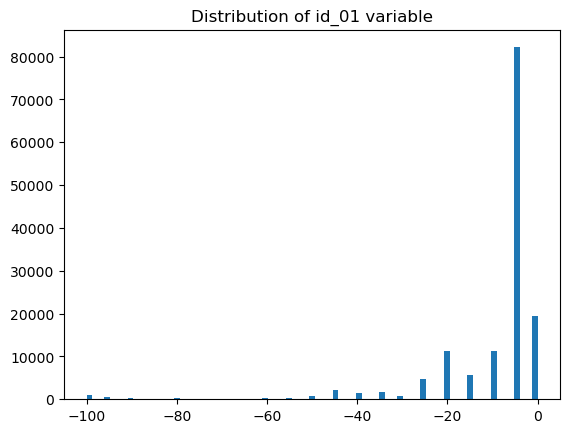

In [11]:
plt.hist(train['id_01'], bins=77);
plt.title('Distribution of id_01 variable');

`id_01` has an interesting distribution: it has 77 unique non-positive values with skeweness to 0.

In [12]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

id_03
NaN    0.887689233582822
0.0    0.108211128797372
1.0    0.001461374335354
3.0    0.001131168083449
2.0    0.000712906831036
Name: proportion, dtype: float64

`id_03` has 88% of missing values and 98% of values are either missing or equal to 0.

In [13]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

id_11
NaN                    0.761272733430420
100.000000000000000    0.225491922647069
95.080001831054673     0.002084532800488
95.160003662109375     0.001276797507366
97.120002746582045     0.000745080773529
Name: proportion, dtype: float64

22% of values in `id_11` are equal to 100and 76% are missing. Quite strange.

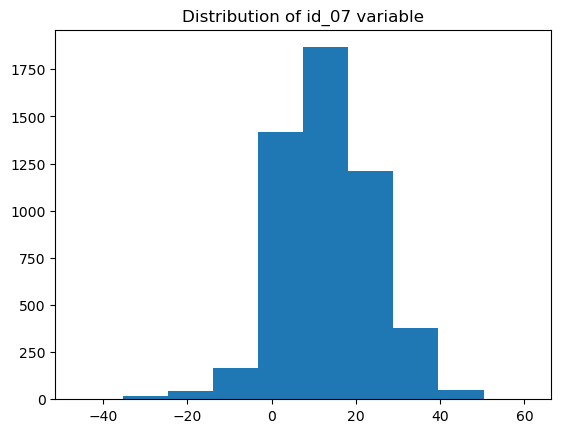

In [14]:
plt.hist(train['id_07']);
plt.title('Distribution of id_07 variable');

Some of features seem to be normalized. So if someone wants to normalize all variables, it would be necessary to separate such variables which seem to be already normalized.

In [17]:
charts = {}
for i in ['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']:
    feature_count = train[i].value_counts(dropna=False).reset_index()
    feature_count.columns = [i, 'count']  # Ensure unique column names
    chart = alt.Chart(feature_count).mark_bar().encode(
                y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
                x=alt.X('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=400)
    charts[i] = chart                         

render((charts['id_12'] | charts['id_15'] | charts['id_16']) & (charts['id_28'] | charts['id_29'] | charts['id_32']) & (charts['id_34'] | charts['id_35'] | charts['id_36']) & (charts['id_37'] | charts['id_38']))

We have several features showing some kind of "found" status and several binary columns.

In [19]:
charts = {}
for i in ['id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo']:
    feature_count = train[i].value_counts(dropna=False)[:40].reset_index()
    feature_count.columns = [i, 'count']  # Ensure unique column names
    chart = alt.Chart(feature_count).mark_bar().encode(
                x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
                y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=800)
    charts[i] = chart
    
render(charts['id_30'] & charts['id_31'] & charts['id_33'] & charts['DeviceType'] & charts['DeviceInfo'])

Here we can see some information about client's device. It is important to be careful here - some of info could be for old devices and may be absent from test data.

Now let's have a look at transaction data.

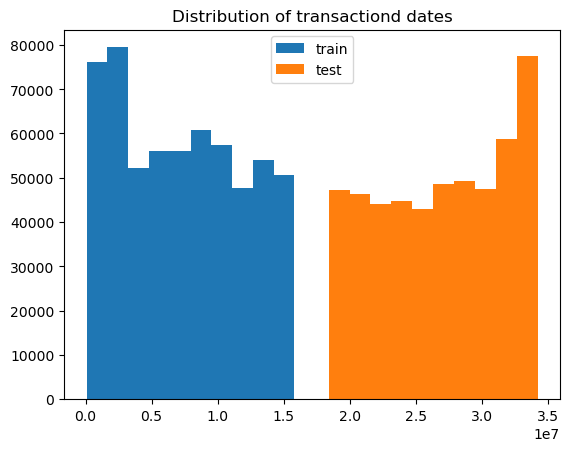

In [20]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');

A very important idea: it seems that train and test transaction dates don't overlap, so it would be prudent to use time-based split for validation.
This was already noted in abother kernel: https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

In [22]:
charts = {}
for i in ['ProductCD', 'card4', 'card6', 'M4', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']:
    feature_count = train[i].value_counts(dropna=False).reset_index()
    feature_count.columns = [i, 'count']  # Ensure unique column names
    chart = alt.Chart(feature_count).mark_bar().encode(
                y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
                x=alt.X('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=400)
    charts[i] = chart                         
    
render((charts['ProductCD'] | charts['card4']) & (charts['card6'] | charts['M4']) & (charts['card6'] | charts['M4']) & (charts['M1'] | charts['M2']) & (charts['M3'] | charts['M5']) & (charts['M6'] | charts['M7']) & (charts['M8'] | charts['M9']))

So `card6` is type of card, `card4` is credit card company

In [24]:
charts = {}
for i in ['P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2']:
    feature_count = train[i].value_counts(dropna=False).reset_index()[:40]
    feature_count.columns = [i, 'count']  # Ensure unique column names
    chart = alt.Chart(feature_count).mark_bar().encode(
                x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
                y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=600)
    charts[i] = chart
    
render((charts['P_emaildomain'] | charts['R_emaildomain']) & (charts['card1'] | charts['card2']) & (charts['card3'] | charts['card5']) & (charts['addr1'] | charts['addr2']))

## Feature engineering

Let's create some aggregations. There is no logic in them - simply aggregations on top features.

In [28]:
import numpy as np
for df in [train, test]:
    # TransactionAmt features
    df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby('card1')['TransactionAmt'].transform('mean').replace(0, np.nan)
    df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby('card4')['TransactionAmt'].transform('mean').replace(0, np.nan)
    df['TransactionAmt_to_std_card1'] = df['TransactionAmt'] / df.groupby('card1')['TransactionAmt'].transform('std').replace(0, np.nan)
    df['TransactionAmt_to_std_card4'] = df['TransactionAmt'] / df.groupby('card4')['TransactionAmt'].transform('std').replace(0, np.nan)

    # id_02 features
    df['id_02_to_mean_card1'] = df['id_02'] / df.groupby('card1')['id_02'].transform('mean').replace(0, np.nan)
    df['id_02_to_mean_card4'] = df['id_02'] / df.groupby('card4')['id_02'].transform('mean').replace(0, np.nan)
    df['id_02_to_std_card1'] = df['id_02'] / df.groupby('card1')['id_02'].transform('std').replace(0, np.nan)
    df['id_02_to_std_card4'] = df['id_02'] / df.groupby('card4')['id_02'].transform('std').replace(0, np.nan)

    # D15 features
    df['D15_to_mean_card1'] = df['D15'] / df.groupby('card1')['D15'].transform('mean').replace(0, np.nan)
    df['D15_to_mean_card4'] = df['D15'] / df.groupby('card4')['D15'].transform('mean').replace(0, np.nan)
    df['D15_to_std_card1'] = df['D15'] / df.groupby('card1')['D15'].transform('std').replace(0, np.nan)
    df['D15_to_std_card4'] = df['D15'] / df.groupby('card4')['D15'].transform('std').replace(0, np.nan)
    df['D15_to_mean_addr1'] = df['D15'] / df.groupby('addr1')['D15'].transform('mean').replace(0, np.nan)
    df['D15_to_mean_addr2'] = df['D15'] / df.groupby('addr2')['D15'].transform('mean').replace(0, np.nan)
    df['D15_to_std_addr1'] = df['D15'] / df.groupby('addr1')['D15'].transform('std').replace(0, np.nan)
    df['D15_to_std_addr2'] = df['D15'] / df.groupby('addr2')['D15'].transform('std').replace(0, np.nan)

    # Fill inf and NaN with 0 for only the new columns
    new_cols = [col for col in df.columns if '_to_' in col]
    df[new_cols] = df[new_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

KeyError: 'id_02'

In [ ]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

## Prepare data for modelling

In [ ]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [ ]:
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [ ]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

84

In [ ]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [ ]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [ ]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]

In [ ]:
# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )

In [ ]:
gc.collect()

47

## LGBM

In [ ]:
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

Fold 1 started at Tue Sep  3 02:30:40 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.994129	training's auc: 0.994129	valid_1's auc: 0.91933	valid_1's auc: 0.91933
Early stopping, best iteration is:
[513]	training's auc: 0.994404	training's auc: 0.994404	valid_1's auc: 0.919435	valid_1's auc: 0.919435
Fold 2 started at Tue Sep  3 02:42:12 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.994715	training's auc: 0.994715	valid_1's auc: 0.931595	valid_1's auc: 0.931595
Early stopping, best iteration is:
[546]	training's auc: 0.995664	training's auc: 0.995664	valid_1's auc: 0.931982	valid_1's auc: 0.931982
Fold 3 started at Tue Sep  3 02:54:10 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.994741	training's auc: 0.994741	valid_1's auc: 0.926174	valid_1's auc: 0.926174
Early stopping, best iteration is:
[372]	training's auc: 0.990799	training's auc: 0.990799	val

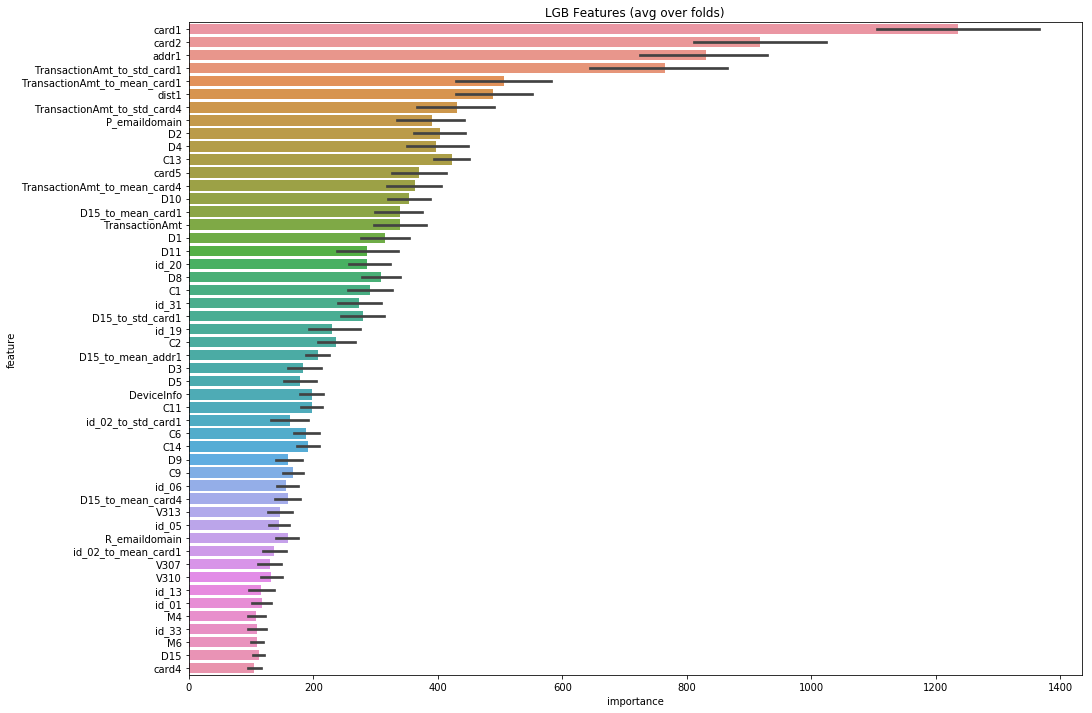

In [ ]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [ ]:
sub['isFraud'] = result_dict_lgb['prediction']
sub.to_csv('submission.csv', index=False)

In [ ]:
sub.head()

,TransactionID,isFraud
0,3663549,0.001571974543870
1,3663550,0.001823337471988
2,3663551,0.003487491775315
3,3663552,0.001593888169964
4,3663553,0.002441269688730


In [ ]:
pd.DataFrame(result_dict_lgb['oof']).to_csv('lgb_oof.csv', index=False)

## Blending

In [ ]:
# xgb_params = {'eta': 0.04,
#               'max_depth': 5,
#               'subsample': 0.85,
#               'objective': 'binary:logistic',
#               'eval_metric': 'auc',
#               'silent': True,
#               'nthread': -1,
#               'tree_method': 'gpu_hist'}
# result_dict_xgb = train_model_classification(X=X, X_test=X_test, y=y, params=xgb_params, folds=folds, model_type='xgb', eval_metric='auc', plot_feature_importance=False,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='rank')

In [ ]:
# test = test.sort_values('TransactionDT')
# test['prediction'] = result_dict_xgb['prediction']
# sub['isFraud'] = pd.merge(sub, test, on='TransactionID')['prediction']
# sub.to_csv('submission_xgb.csv', index=False)

In [ ]:
# test = test.sort_values('TransactionDT')
# test['prediction'] = result_dict_lgb['prediction'] + result_dict_xgb['prediction']
# sub['isFraud'] = pd.merge(sub, test, on='TransactionID')['prediction']
# sub.to_csv('blend.csv', index=False)